In [83]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from pylab import rcParams
from keras import regularizers
from keras.layers import Input, Dense
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import precision_recall_fscore_support

# Dataload&Preprocessing

In [57]:
df=pd.read_csv('../dataset/WISDM.csv', index_col=0)
df = df.drop(columns=['user-id', 'timestamp'])

df

,activity,X,Y,Z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164
...,...,...,...,...
1098199,Sitting,9.000000,-1.570000,1.690000
1098200,Sitting,9.040000,-1.460000,1.730000
1098201,Sitting,9.080000,-1.380000,1.690000
1098202,Sitting,9.000000,-1.460000,1.730000


# Jogging&Sitting 제외 모두 drop

In [58]:
activities = df['activity'].unique() # activity 열의 고유한 값 확인

print(activities) # 고유한 활동 출력

['Jogging' 'Walking' 'Upstairs' 'Downstairs' 'Sitting' 'Standing']


In [59]:
# 'Jogging'과 'Sitting'을 제외한 나머지 활동을 삭제
df = df[df['activity'].isin(['Jogging', 'Sitting'])]

df

,activity,X,Y,Z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164
...,...,...,...,...
1098199,Sitting,9.000000,-1.570000,1.690000
1098200,Sitting,9.040000,-1.460000,1.730000
1098201,Sitting,9.080000,-1.380000,1.690000
1098202,Sitting,9.000000,-1.460000,1.730000


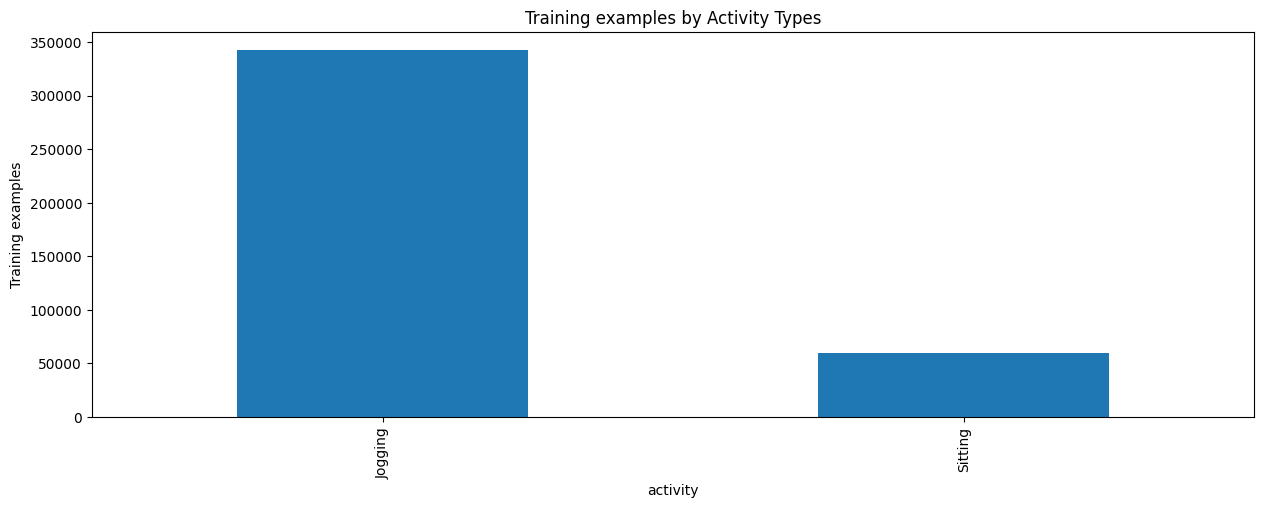

In [60]:
# 첫 번째 그래프: Activity Type에 따른 훈련 예제 수를 막대 그래프로 표시
plt.figure(figsize=(15, 5))  # 그래프의 크기를 설정
plt.xlabel('Activity Type')  # x 축 레이블 설정
plt.ylabel('Training examples')  # y 축 레이블 설정
df['activity'].value_counts().plot(kind='bar',  # 'activity' 열의 값 수를 막대 그래프로 표시
                                  title='Training examples by Activity Types')  # 그래프 제목 설정
plt.show()  # 그래프를 화면에 표시

# Jogging&Sitting selection(4500)

In [61]:
# 'Jogging'과 'Sitting'을 각각 4500개씩만 선택
Jogging = df[df['activity'] == 'Jogging'].head(4499).copy()
Sitting = df[df['activity'] == 'Sitting'].head(4500).copy()

# Data balancing

In [62]:
balanced_data = pd.DataFrame()
balanced_data = pd.concat([balanced_data, Jogging, Sitting]) # concat(): 두 DF을 합쳐 새 DF를 생성.

balanced_data.shape

(8999, 4)

In [63]:
balanced_data

,activity,X,Y,Z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164
...,...,...,...,...
255294,Sitting,-4.330000,-2.180000,8.308413
255295,Sitting,-4.370000,-2.220000,8.349273
255296,Sitting,-4.290000,-2.220000,8.308413
255297,Sitting,-4.290000,-2.220000,8.281172


In [64]:
balanced_data['activity'].value_counts()

activity
Sitting    4500
Jogging    4499
Name: count, dtype: int64

# LabelEncoding

In [65]:
le=LabelEncoder()

# label인코딩으로 activity의 범주형data를 숫자로 변환
balanced_data['activity']=le.fit_transform(balanced_data['activity']) # fit_transform메서드: data에 대한 변환 규칙 학습, 이를 기반으로 data 변환.

# Train/Test split

In [66]:
X_train, X_test = train_test_split(balanced_data, train_size=0.75, random_state=42)
X_train.shape, X_test.shape

((6749, 4), (2250, 4))

In [67]:
# Normal = 0, Fall = 1
normal = X_train[X_train['activity'] == 0]

y_train = normal['activity']
X_train_normal_train = normal.drop(['activity'], axis=1)

y_test = X_test['activity']
X_test = X_test.drop(['activity'], axis=1)

X_train_ft = X_train_normal_train.values
X_test = X_test.values

# Auto Encoder

In [70]:
input_dim = X_train_normal_train.shape[1] # 입력 데이터의 차원(특성의 개수)
encoding_dim = 14 # Encoder의 Hidden Layer의 차원(뉴런의 개수)

# Input Layer 정의
input_layer = Input(shape=(input_dim, ))

# Encoder 정의
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

# Decoder 정의
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

# Auto Encoder 정의
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [71]:
#nb_epoch = 100
nb_epoch = 10
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', # loss()로 평균 제곱 오차
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="./model.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='/logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
# Autoencoder Model Train
history = autoencoder.fit(X_train_normal_train, X_train_normal_train,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_split=0.1,
                          verbose=1,
                          callbacks=[checkpointer, tensorboard]).history

Epoch 1/10
96/96 [==============================] - 1s 3ms/step - loss: 67.2592 - accuracy: 0.1246 - val_loss: 65.7627 - val_accuracy: 0.1824
Epoch 2/10
96/96 [==============================] - 0s 2ms/step - loss: 59.1143 - accuracy: 0.4691 - val_loss: 49.7485 - val_accuracy: 0.7471
Epoch 3/10
96/96 [==============================] - 0s 2ms/step - loss: 45.8117 - accuracy: 0.7597 - val_loss: 41.1992 - val_accuracy: 0.7765
Epoch 4/10
96/96 [==============================] - 0s 2ms/step - loss: 39.4742 - accuracy: 0.7797 - val_loss: 36.7091 - val_accuracy: 0.7794
Epoch 5/10
96/96 [==============================] - 0s 2ms/step - loss: 35.8069 - accuracy: 0.7833 - val_loss: 33.7152 - val_accuracy: 0.7912
Epoch 6/10
96/96 [==============================] - 0s 2ms/step - loss: 33.0336 - accuracy: 0.7908 - val_loss: 31.2953 - val_accuracy: 0.7912
Epoch 7/10
96/96 [==============================] - 0s 2ms/step - loss: 30.6774 - accuracy: 0.7960 - val_loss: 29.1541 - val_accuracy: 0.8059
Epoch 

In [74]:
# 테스트 데이터 수정
X_test = X_test

# AutoEncoder를 사용해 테스트 데이터 예측
predictions = autoencoder.predict(X_test)

# 예측과 실제 데이터 간의 평균 제곱 오차(MSE) 계산
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

# 오차와 실제 클래스 정보를 포함하는 DF 생성
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

error_df.describe()  # 생성된 DF의 기술통계량 확인

71/71 [==============================] - 0s 826us/step


,reconstruction_error,true_class
count,2250.000000,2250.000000
mean,16.652380,0.511111
std,19.790660,0.499988
min,0.043596,0.000000
25%,1.833793,0.000000
50%,13.575739,1.000000
75%,15.789917,1.000000
max,146.884811,1.000000


# 재구성 오차(Reconstruction error) 기반, 이상 감지 모델 결과 시각화

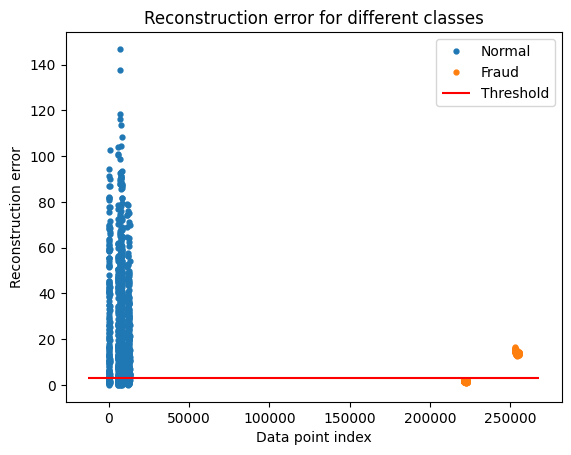

In [78]:
threshold = 3 # 임계값(Threshold 설정)

groups = error_df.groupby('true_class') # True_class에 따른 data group화

fig, ax = plt.subplots() # Graph 생성

# 각 Group에 대한 재구성 오차 플로팅
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
# 임계값을 Red line으로 설정
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

# Graph title & Label 설정
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Threshold(임계값)을 기준, Reconstruction_error(오차)로 할당

In [79]:
LABELS = ["Normal", "AbNormal"]

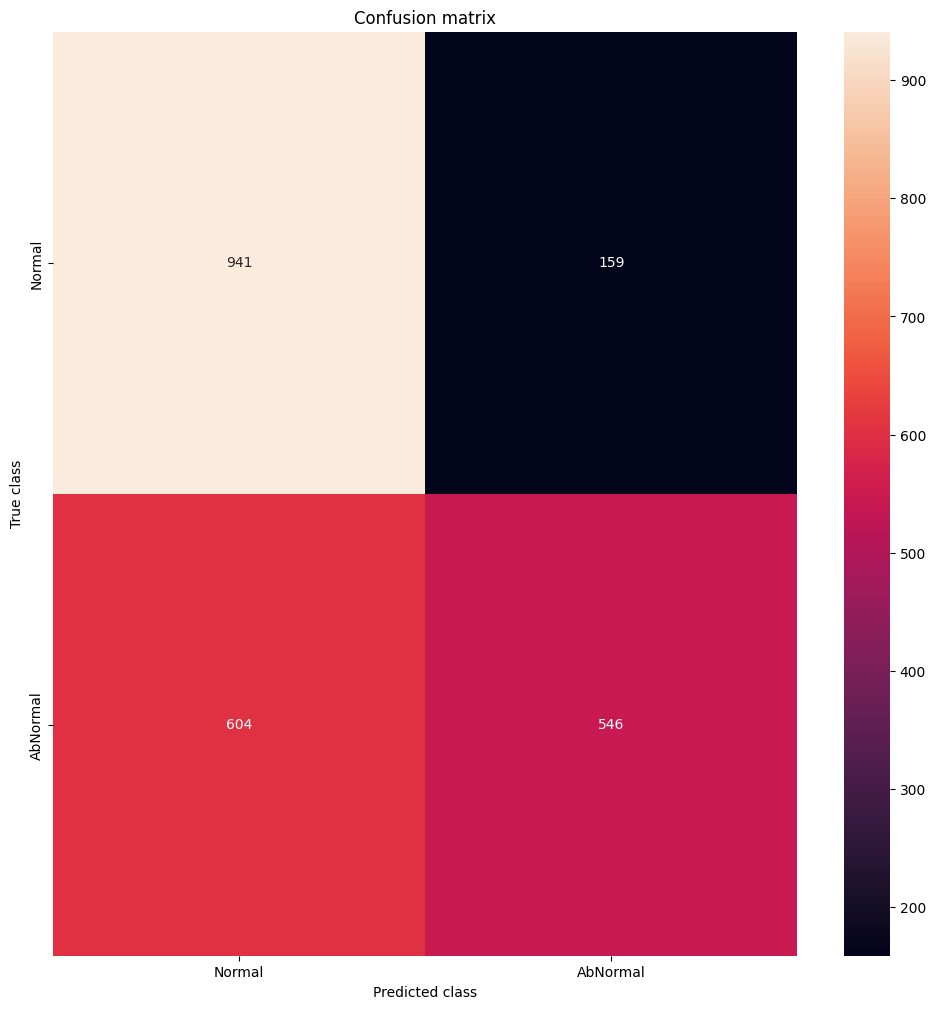

In [84]:
# 오류값이 임계값보다 크면 0, 아니면 1 -> 임계값을 기준으로 정상/비정상 Classification
y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.true_class, y_pred) # 혼동 행렬 계산

# Hit-map 작성
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");

plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [85]:
precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')

In [86]:
print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.6608888888888889
Precision : 0.774468085106383
Recall : 0.4747826086956522
F1 : 0.588679245283019


# Denoising Autoencoder

In [ ]:
가우시안노이즈 사용